# <p style="text-align: center;"> CS6476 | Computer Vision ps5 </p>
<p style="text-align: center;">Alexis Durocher - MSCS student at Georgia Tech</p>
<p style="text-align: center;">Spring 2018</p>


In [220]:
import cv2

from scipy import ndimage
from scipy import misc
import math as mt
import numpy as np
import math as mtugh
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from  scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

<i> In this project, the aim is Finally, we  </i>

In [2]:
def image_pair(image1, image2):
    return np.concatenate([image1, image2], axis =1)

In [3]:
kernel_x = np.array([[-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]])

kernel_y = np.array([[-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1]])

### 1. Laplacian/Gaussian pyramids

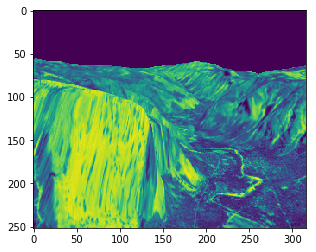

In [4]:
yos_1 = cv2.imread('./images/DataSeq1/yos_img_01.jpg', 0)
yos_2 = cv2.imread('./images/DataSeq1/yos_img_02.jpg', 0)
yos_3 = cv2.imread('./images/DataSeq1/yos_img_03.jpg', 0)
plt.imshow(yos_1)
plt.show()

#### 1.1  Reduce

In [5]:
def reduce(img, k):
    """
    @summary reduce /2 a version of a given image, k times
    @params img: source image
    """
    reduced = img.copy()
    for i in range(0, k):
        reduced = cv2.resize(reduced, (0,0), fx = 0.5, fy = 0.5)
    return reduced

def get_gaussian_pyramid(image, n_levels = 4):
    gaussian_pyramid = {}
    gaussian_pyramid[0] = image

    for level in range(0, n_levels-1):
        img_n = gaussian_pyramid[level]
        smoothed = cv2.GaussianBlur(img_n,(5,5),0)
        gaussian_pyramid[level+1] = reduce(smoothed, 1)
    return gaussian_pyramid

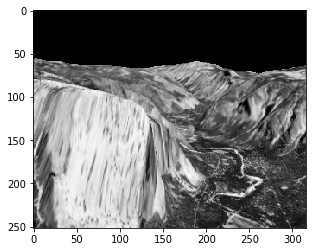

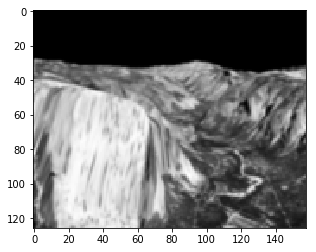

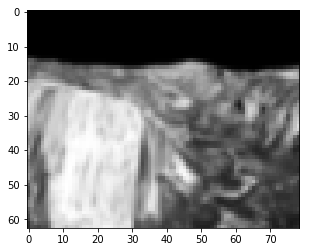

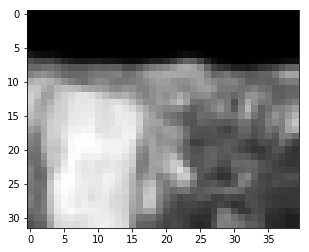

In [6]:
gaussian_pyramid = get_gaussian_pyramid(yos_1, 4)

for level, image in gaussian_pyramid.items():
    plt.imshow(image, cmap ='gray')
    plt.savefig('./output/PS5-1-1-'+str(level)+'.png')
    plt.show()

#### 1.2 Expand 

In [7]:
def expand(img, size):
    expanded = cv2.resize(img, size)
    return expanded

def get_laplacian_pyramid(image, n_levels):
    gaussian_pyramid = get_gaussian_pyramid(image, n_levels)
    laplacian_pyramid = {}
    for key, image in gaussian_pyramid.items():
        if (key == n_levels -1):
            laplacian_pyramid[key] = image
        else:
            level_img = gaussian_pyramid[key]
            level_plus_1_img = gaussian_pyramid[int(key) + 1]
            h, w = level_img.shape
            expanded = expand(level_plus_1_img, (w,h)) 
            laplacian_pyramid[key] = level_img - expanded
    return laplacian_pyramid

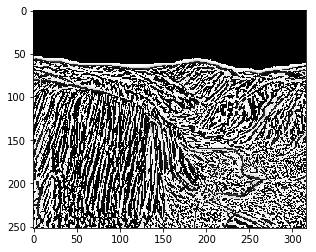

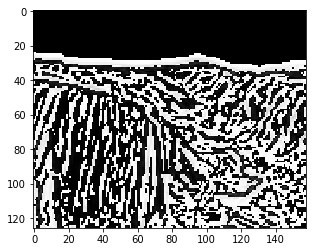

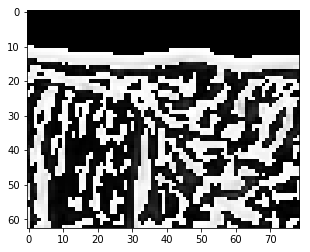

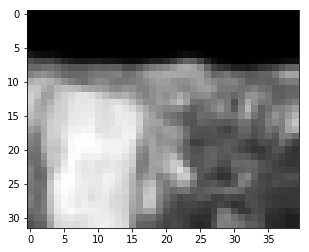

In [8]:
laplacian_pyramid = get_laplacian_pyramid(yos_1, 4)
for level, image in laplacian_pyramid.items():
    plt.imshow(image, cmap ='gray')
    plt.savefig('./output/PS5-1-2-'+str(level)+'.png')
    plt.show()

#### 2. Lucas Kanade

Image U are shift values from image 1 to image 2 along x axis (shift in columns value)

Image V are shift values from image 1 to image 2 along y axis (shigt in rows value)

In [88]:
shift0 = cv2.imread('./images/TestSeq/Shift0.png', 0)
shiftR2 = cv2.imread('./images/TestSeq/ShiftR2.png', 0)
shiftR5U5 = cv2.imread('./images/TestSeq/ShiftR5U5.png', 0)
shiftR10 = cv2.imread('./images/TestSeq/ShiftR10.png', 0)
shiftR20 = cv2.imread('./images/TestSeq/ShiftR20.png', 0)
shiftR40 = cv2.imread('./images/TestSeq/ShiftR40.png', 0)
shift0_smo = cv2.GaussianBlur(shift0, (3,3), 5)
shiftR2_smo = cv2.GaussianBlur(shiftR2, (3,3), 5)
shiftR5U5_smo = cv2.GaussianBlur(shiftR5U5, (3,3), 5)
shiftR10_smo = cv2.GaussianBlur(shiftR10, (3,3),5)
shiftR20_smo = cv2.GaussianBlur(shiftR20, (3,3), 5)
shiftR40_smo = cv2.GaussianBlur(shiftR40, (3,3), 5)

In [89]:
def compute_sum(image, ks, r, c):
    sum_tot = image[r-ks:r+ks+1, c-ks:c+ks+1].sum()
    return sum_tot

def solve_lk(mat_grads, mat_t):
    a, b, c, d = mat_grads[0,0], mat_grads[0,1], mat_grads[1,0], mat_grads[1,1]
    e, f = mat_t[0], mat_t[1]
    v = (-f + (c*e)/a) / ( d - (b*c)/a)
    u = (-e - b*v) / a
    return u, v

def solve_lk_mat(mat_grads, mat_t, epsilon = 1e-10):
    vec = np.zeros((2,1))
    if np.linalg.det(mat_grads) > epsilon:
        vec = np.dot(np.linalg.inv(mat_grads), - mat_t)
    return vec[0], vec[1]

In [90]:
def compute_lk(image1, image2, window_size = 10):
    ks = int((window_size-1)/2)
    It = cv2.subtract(image2, image1)
    Ix, Iy = np.gradient(image1)
    # weighted sum : gaussian kernel
    weights = cv2.getGaussianKernel(window_size, sigma = 3)
    tuple_w = (window_size, window_size)
    # matrix components
    
    Ixx = cv2.boxFilter(Ix * Ix, -1, tuple_w)
    Iyy = cv2.boxFilter(Iy * Iy, -1, tuple_w)
    Ixy = cv2.boxFilter(Ix * Iy, -1, tuple_w)
    Itx = cv2.boxFilter(It * Ix, -1, tuple_w)
    Ity = cv2.boxFilter(It * Iy, -1, tuple_w)
    
    image_u, image_v = np.zeros(image1.shape), np.zeros(image1.shape)
    height, width = image1.shape
    for r in range(ks, height-ks):
        for c in range(ks, width-ks):
            el1 = Ixx[r, c]
            el2 = Iyy[r, c]
            el3 = Ixy[r, c]
            el4 = Itx[r, c]
            el5 = Ity[r, c]
            mat_grads = np.array([
                [el1, el3],
                [el3, el2]
            ], np.float32)
            mat_t = np.array([el4, el5], np.float32)
            u, v = solve_lk_mat(mat_grads, mat_t)
            image_u[r, c] = u
            image_v[r, c] = v
    # use the max val to normalize
    return image_u, image_v

In [91]:
def quiver_flow(img, flow_u, flow_v, step_fac = 50):
    x = np.arange(0, img.shape[1], 1)
    y = np.arange(0, img.shape[0], 1)
    x, y = np.meshgrid(x, y)
    plt.figure(figsize=(10,5))
    fig = plt.imshow(img, cmap = 'gray')
    # step to be display
    step = int(img.shape[0] / step_fac)
    plt.quiver(x[::step], y[::step],
               flow_u[::step], flow_v[::step], color = 'r',
               pivot = 'middle', headwidth=1, headlength =2)
    return plt

#### 2.1 Lukas Kanade : shift 2 right 

In [92]:
shiftR2_u, shiftR2_v = compute_lk(shift0_smo, shiftR2_smo, 10)

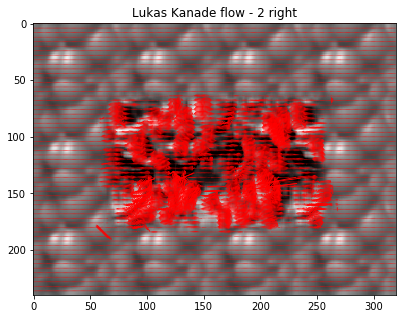

In [93]:
plt = quiver_flow(shift0, shiftR2_u, shiftR2_v)
plt.title('Lukas Kanade flow - 2 right')
plt.show()

#### Lukas Kanade : shift 2 right / 5 up

In [86]:
shiftR5U5_U, shiftR5U5_V = compute_lk(shift0_smo, shiftR5U5_smo, 10)

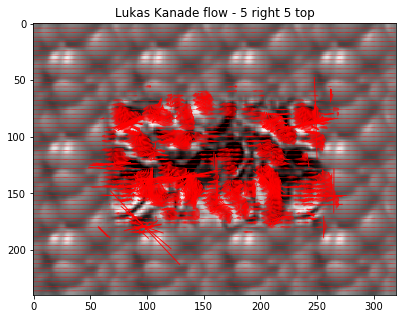

In [87]:
plt = quiver_flow(shift0, shiftR5U5_U, shiftR5U5_V)
plt.title('Lukas Kanade flow - 5 right 5 top')
plt.show()

#### 2.2 Lukas Kanade : big shift 10, 20, 40

In [17]:
shiftR10_U, shiftR10_V = compute_lk(shift0_smo, shiftR10_smo , 10)
shiftR20_U, shiftR20_V = compute_lk(shift0_smo, shiftR20_smo , 10)
shiftR40_U, shiftR40_V = compute_lk(shift0_smo, shiftR40_smo , 10)

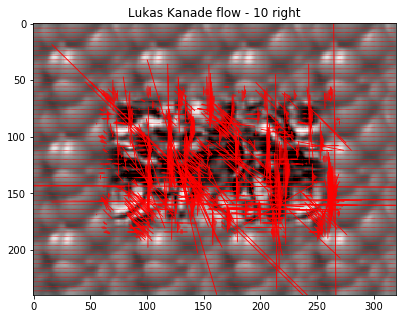

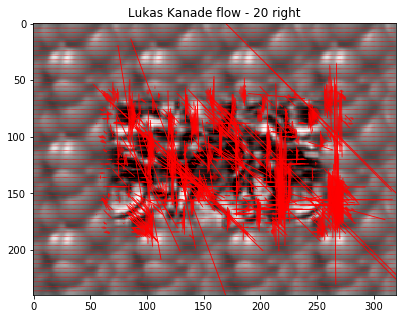

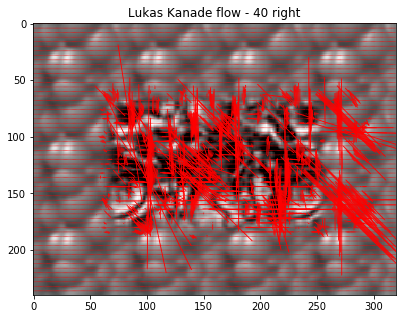

In [18]:
plt = quiver_flow(shift0, shiftR10_U, shiftR10_V)
plt.title('Lukas Kanade flow - 10 right')
plt.show()
plt = quiver_flow(shift0, shiftR20_U, shiftR20_V)
plt.title('Lukas Kanade flow - 20 right')
plt.show()
plt = quiver_flow(shift0, shiftR40_U, shiftR40_V)
plt.title('Lukas Kanade flow - 40 right')
plt.show()

<u> Interpretation </u>
Flow are not consistent because LK assumes a small shift in the pixel from one image to an other. Here, for pixels' shift higher than 10, the assumptions are not verified anymore.

#### 2.3 Warp

In [19]:
# return a backed warp image
def warp_back(img2, flow_u, flow_v):
    """
    @summary compute a warped back(img1) version of img2
    @params img2: the src image (shifted)
    @params flow_u: the shift along x axis, from img1 to img2
    @params flow_v: the shift along y axis, from img1 to img2
    """
    x = np.arange(0, img2.shape[1], 1) # width
    y = np.arange(0, img2.shape[0], 1) # height
    x, y = np.meshgrid(x, y)
    map_x = np.array(x + flow_u, dtype=np.float32)
    map_y = np.array(y + flow_v, dtype=np.float32)
    warpI2 = cv2.remap(img2, map_x, map_y, interpolation = cv2.INTER_LINEAR)
    # note : we need a second warping for NaN value due to linear interpolation
    warpI2bis = cv2.remap(img2, map_x, map_y, interpolation = cv2.INTER_NEAREST)
    warpI2[warpI2 == np.NAN] = warpI2bis[warpI2 == np.NaN]
    return warpI2

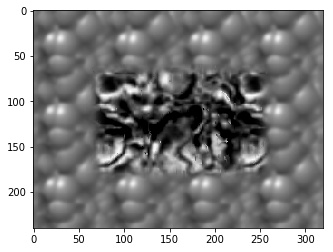

In [20]:
warped_shiftR2 = warp_back(shiftR2, shiftR2_u,  shiftR2_v)
plt.imshow(warped_shiftR2, cmap = 'gray')
plt.show()

<u> Interpretation </u>

The warped back image is aligning with shiftR0. Indeed this is a back warp so the output corresponds to 

<u> Applied on DataSequence 1 </u>

In [96]:
dataseq1_1 = cv2.imread('./images/DataSeq1/yos_img_01.jpg', 0);
dataseq1_2 = cv2.imread('./images/DataSeq1/yos_img_02.jpg', 0);
dataseq1_3 = cv2.imread('./images/DataSeq1/yos_img_03.jpg', 0);

dataseq1_2_flowu, dataseq1_2_flowv = compute_lk(dataseq1_1, dataseq1_2)
dataseq1_3_flowu, dataseq1_3_flowv = compute_lk(dataseq1_2, dataseq1_3)

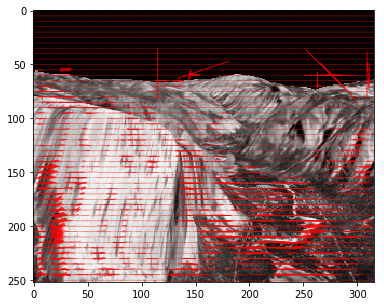

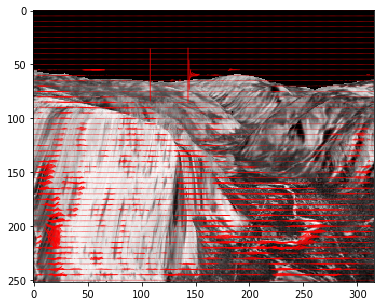

In [98]:
# plot flows
plt = quiver_flow(dataseq1_1, dataseq1_2_flowu, dataseq1_2_flowv)
plt.show()

plt = quiver_flow(dataseq1_2, dataseq1_3_flowu, dataseq1_3_flowv)
plt.show()

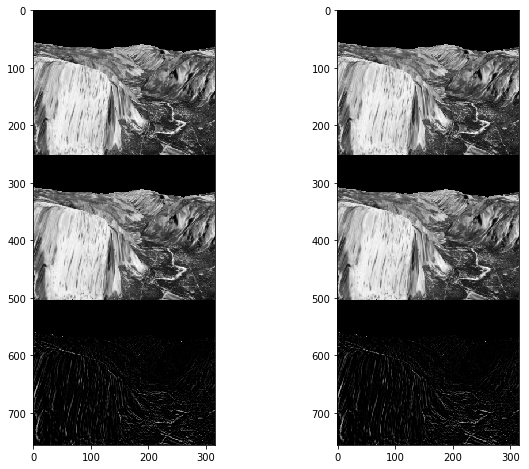

In [99]:
# plot warped comparisons
dataseq1_1_warped = warp_back(dataseq1_2, dataseq1_2_flowu, dataseq1_2_flowv)
dataseq1_1_diff = cv2.subtract(dataseq1_1, dataseq1_2)
dataseq1_1_comp = np.vstack((dataseq1_1, dataseq1_1_warped, dataseq1_1_diff))

dataseq1_2_warped = warp_back(dataseq1_3, dataseq1_3_flowu, dataseq1_3_flowv)
dataseq1_2_diff = cv2.subtract(dataseq1_2, dataseq1_3)
dataseq1_2_comp = np.vstack((dataseq1_2, dataseq1_2_warped, dataseq1_2_diff))

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,2,1)
ax.imshow(dataseq1_1_comp, cmap ='gray')
bx = fig.add_subplot(1,2,2)
bx.imshow(dataseq1_1_comp, cmap ='gray')
plt.show()

<u> Applied on DataSequence 2 </u>

In [100]:
dataseq2_1 = cv2.imread('./images/DataSeq2/0.png', 0);
dataseq2_2 = cv2.imread('./images/DataSeq2/1.png', 0);
dataseq2_3 = cv2.imread('./images/DataSeq2/2.png', 0);

dataseq2_2_flowu, dataseq2_2_flowv = compute_lk(dataseq2_1, dataseq2_2)
dataseq2_3_flowu, dataseq2_3_flowv = compute_lk(dataseq2_1, dataseq2_3)

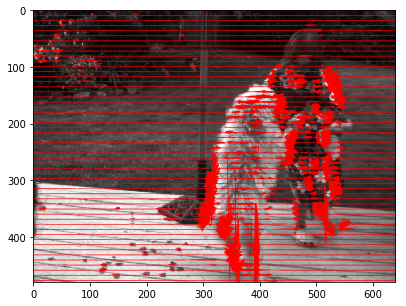

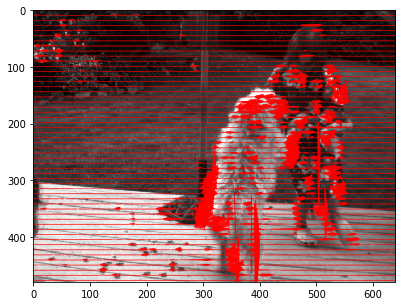

In [102]:
# plot flows
plt = quiver_flow(dataseq2_1, dataseq2_2_flowu, dataseq2_2_flowv)
plt.show()

plt = quiver_flow(dataseq2_2, dataseq2_3_flowu, dataseq2_3_flowv)
plt.show()

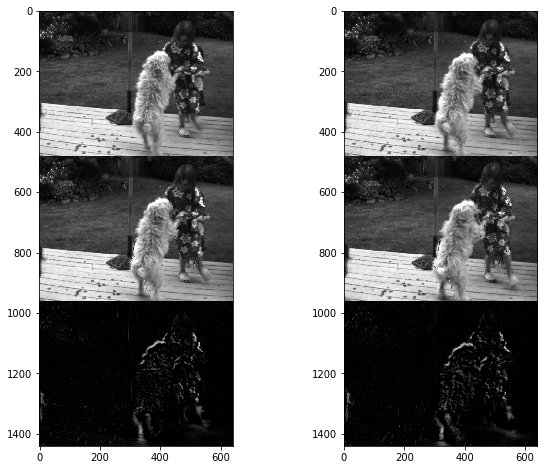

In [26]:
# plot warped comparisons
dataseq2_1_warped = warp_back(dataseq2_2, dataseq2_2_flowu, dataseq2_2_flowv)
dataseq2_1_diff = cv2.subtract(dataseq2_1, dataseq2_2)
dataseq2_1_comp = np.vstack((dataseq2_1, dataseq2_1_warped,dataseq2_1_diff))

dataseq2_2_warped = warp_back(dataseq2_3, dataseq2_3_flowu, dataseq2_3_flowv)
dataseq2_2_diff = cv2.subtract(dataseq2_2, dataseq2_3)
dataseq2_2_comp = np.vstack((dataseq2_2, dataseq2_2_warped, dataseq2_2_diff))


fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,2,1)
ax.imshow(dataseq2_1_comp, cmap ='gray')
bx = fig.add_subplot(1,2,2)
bx.imshow(dataseq2_2_comp, cmap ='gray')
plt.show()

<u> Interpretation </u>
Result are acceptable for both Data Sequence

### 3. Hierarchical K optic flow

#### 3.1

In [103]:
def compute_hiera_LK(input_L, input_R, n = 5, window_size = 5):
    level_k = n
    while level_k > 0:
        # reducing to level_k
        Lk = reduce(input_L, level_k-1)
        Rk = reduce(input_R, level_k-1)
        h,w = Lk.shape
        if level_k == n:
            U, V = np.zeros(Lk.shape), np.zeros(Lk.shape)
        else:
            U, V = 2*expand(U, (w,h)), 2*expand(V, (w,h))
        # warping left image with flow field in x and y
        Wk = warp_back(Lk, U, V)
        # computing lk between warped image Wk and Rk to compute new delta flow fields in x and y
        Dx, Dy = compute_lk(Wk, Rk, window_size)
        # update flow fields
        U, V = U + Dx, V + Dy
        # decrement k
        level_k -= 1
    return U, V, Wk

<u> Shift Right 10 pixel </u>

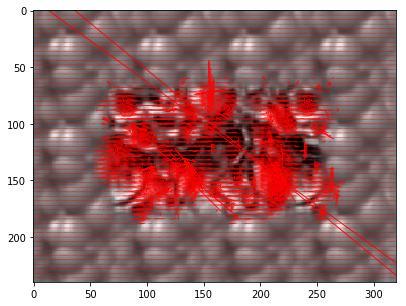

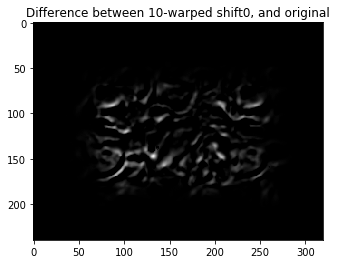

In [104]:
#δ pixels, you’ll need to set n to (at least) log2(δ).
flowU_R10, flowV_R10, warped_L_R10 = compute_hiera_LK(shift0_smo, shiftR10_smo, n = int(np.log2(10) +1))
plt = quiver_flow(shift0, flowU_R10, flowV_R10)
plt.show()
diff_R10 = cv2.subtract(shift0_smo, warped_L_R10)
plt.imshow(diff_R10, cmap='gray')
plt.title('Difference between 10-warped shift0, and original')
plt.show()

<u> Shift R 20 pixels </u>

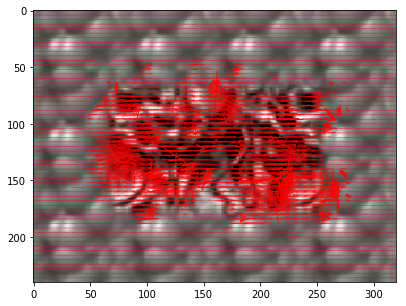

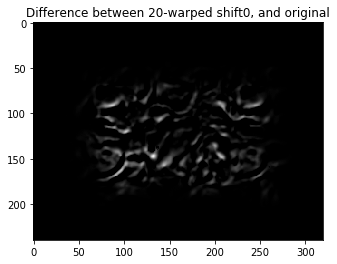

In [105]:
#δ pixels, you’ll need to set n to (at least) log2(δ).
flowU_R20, flowV_R20, warped_L_R20 = compute_hiera_LK(shift0_smo, shiftR20_smo, n = int(np.log2(20) +1))
plt = quiver_flow(shift0, flowU_R20, flowV_R20)
plt.show()
diff_R20 = cv2.subtract(shift0_smo, warped_L_R20)
plt.imshow(diff_R10, cmap='gray')
plt.title('Difference between 20-warped shift0, and original')
plt.show()

<u> Shift R 40 pixels </u>

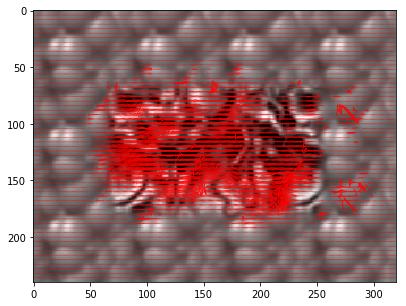

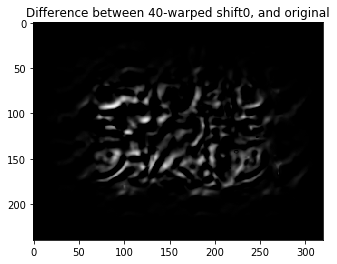

In [106]:
#δ pixels, you’ll need to set n to (at least) log2(δ).
flowU_R40, flowV_R40, warped_L_R40 = compute_hiera_LK(shift0_smo, shiftR40_smo, n = int(np.log2(40) +1))
plt = quiver_flow(shift0, flowU_R40, flowV_R40)
plt.show()
diff_R40 = cv2.subtract(shift0_smo, warped_L_R40)
plt.imshow(diff_R40, cmap='gray')
plt.title('Difference between 40-warped shift0, and original')
plt.show()

### Juggle Sequence

In [107]:
juggle0 = cv2.imread('./images/Juggle/0.png', 0)
juggle1 = cv2.imread('./images/Juggle/1.png', 0)
juggle2 = cv2.imread('./images/Juggle/2.png', 0)
juggle0_smo = cv2.GaussianBlur(juggle0, (5,5), sigmaX = 5, sigmaY =5)
juggle1_smo = cv2.GaussianBlur(juggle1, (5,5), sigmaX = 5, sigmaY =5)
juggle2_smo = cv2.GaussianBlur(juggle2, (5,5), sigmaX = 5, sigmaY =5)

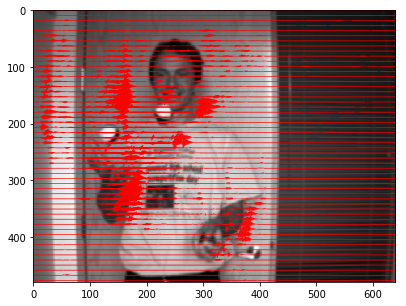

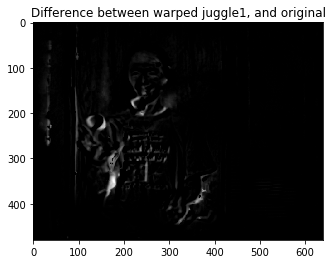

In [108]:
#measuring max shift between image 1 and image 2 : shift of 35 pixels
flowU_juggle, flowV_juggle, warped_juggle = compute_hiera_LK(juggle1_smo, juggle2_smo, n = int(np.log2(35) +1))
plt = quiver_flow(juggle1_smo, flowU_juggle, flowV_juggle)
plt.show()
diff_juggle = cv2.subtract(juggle1_smo, warped_juggle)
plt.imshow(diff_juggle, cmap='gray')
plt.title('Difference between warped juggle1, and original')
plt.show()

#### Lk between image I2 and I1

### Taxi Sequence

In [293]:
temp_taxi = cv2.imread('./images/Taxis/taxi-00.jpg', 0)
h_taxis, w_taxis = temp_taxi.shape

In [315]:
def compute_flows_segmentation(flow_u, flow_v, k = 4, scaled = True):
    """
    compute kmeans on x, y, flow_u and flow_v features
    @params flow_u: flow on x axis 
    @parmas flow_v: flow on y axis
    """
    #prepare spatial features (rows and cols)
    h, w = flow_u.shape
    cols = np.arange(0, w)
    rows = np.arange(0, h)
    cols, rows = np.meshgrid(cols, rows)
    cols = cols.flatten()
    rows = rows.flatten()
    # prepare flows' features (u and v)
    vals_u = flowU_taxi1.flatten()
    vals_v = flowV_taxi1.flatten()
    features_dataframe = pd.DataFrame(data = {
        'rows' : rows,
        'cols' : cols,
        'val_u': vals_u,
        'val_v': vals_v,
    }, columns = ['rows', 'cols', 'val_u', 'val_v'])
    features = features_dataframe.values
    if scaled:
        features = StandardScaler().fit_transform(features)
    kmeans = KMeans( n_clusters= k)
    kmeans.fit(features)
    segmented = np.reshape(kmeans.labels_, flow_u.shape)
    return segmented

def color_img_flow(img, segmented):
    """
    color images according to smaller segments (clusters' label)
    @params img: source image (gray)
    @parmas segmented: segments label
    """
    #color segments
    uniques = np.unique(segmented)
    min_clust = uniques[0]
    min_size = len(segmented.flatten())
    for cluster in uniques:
        size = len(segmented[segmented == cluster])
        if size < min_size:
            min_clust = cluster
            min_size = size
    img[segmented == min_clust] = (0,0,255)       

    return img

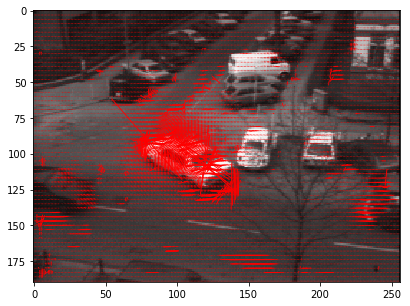

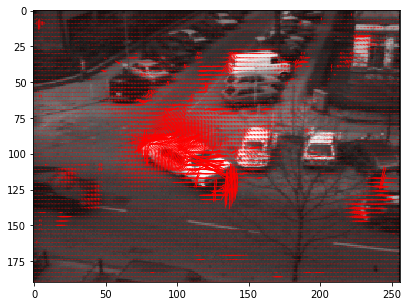

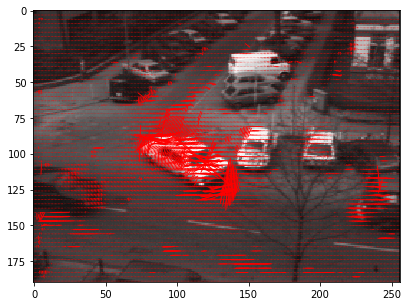

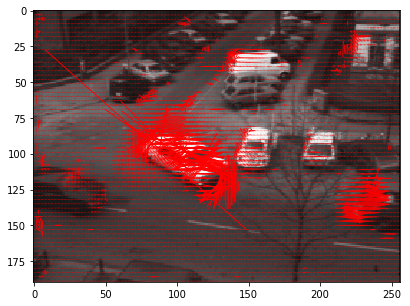

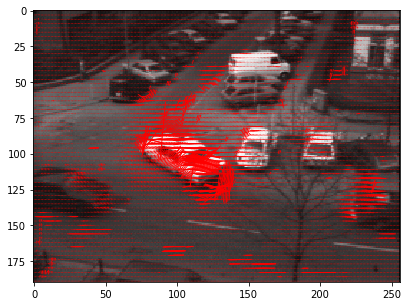

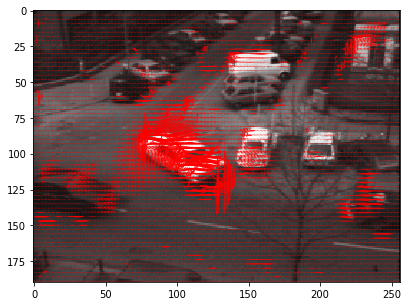

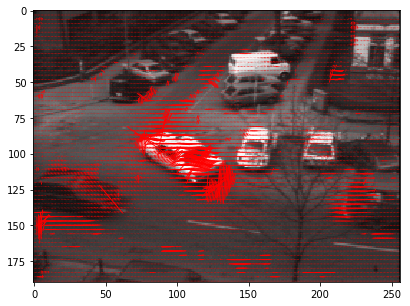

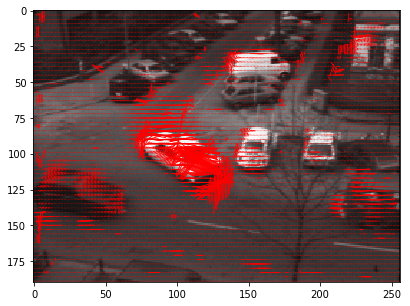

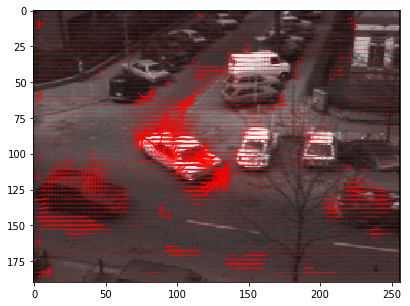

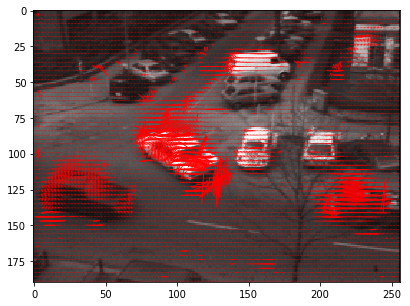

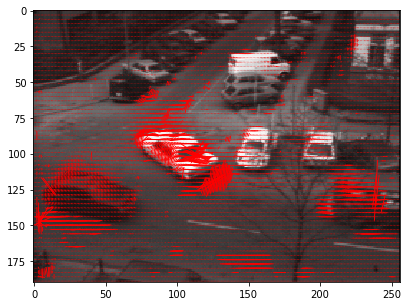

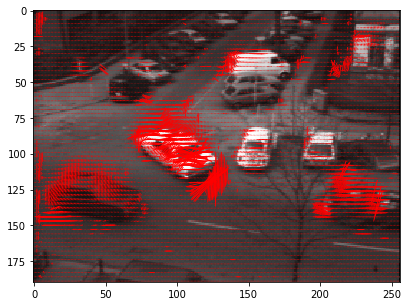

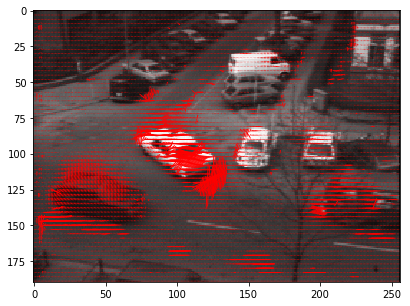

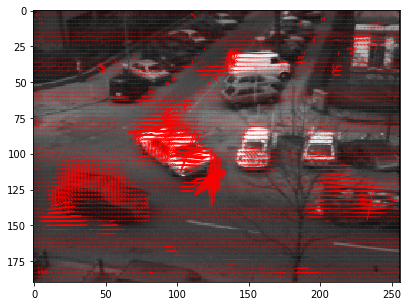

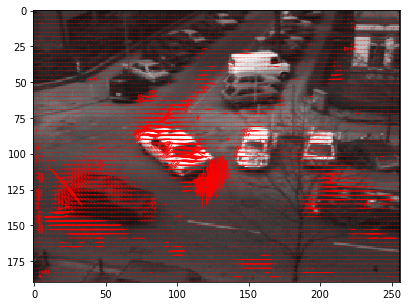

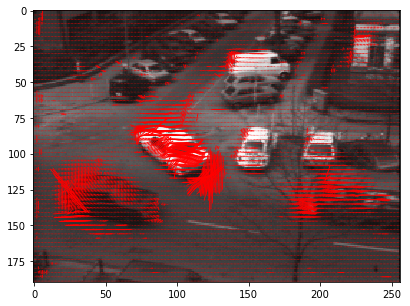

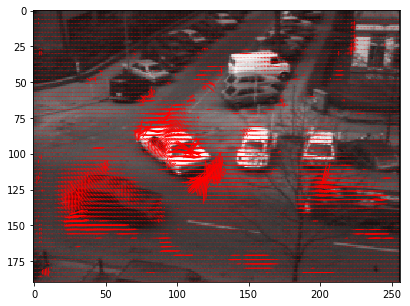

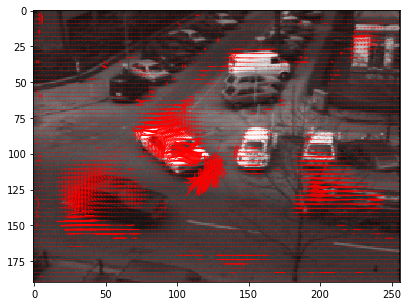

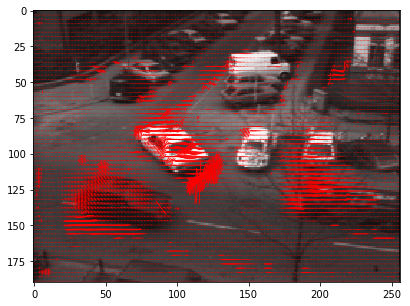

In [316]:
sequence_length = 19
quivers = {}
segmented_flow = {}
colored_flow = cv2.cvtColor(temp_taxi, cv2.COLOR_GRAY2RGB)
for i in range(0, sequence_length):
    # get 00 to 18 and 19 taxi images
    str_i1 = ('0'+str(i))[-2:];
    str_i2 = ('0'+str(i+1))[-2:];
    taxi1 = cv2.imread('./images/Taxis/taxi-'+str_i1+'.jpg', 0)
    taxi2 = cv2.imread('./images/Taxis/taxi-'+str_i2+'.jpg', 0)
    # need smoothing ?
    flowU_taxi1, flowV_taxi1, warpe_taxi1 = compute_hiera_LK(taxi1, taxi2, n = int(np.log2(20) +1))
    quivers[i] = quiver_flow(taxi1, flowU_taxi1, flowV_taxi1)
    quivers[i].show()
    segments = compute_flows_segmentation(flowU_taxi1, flowV_taxi1, k = 4, scaled = True)
    colored_flow = color_img_flow(colored_flow, segments)

<u> Explication </u>

For each pair of images in taxi sequence, we calculated the resulting LK flow.
On top of this flow, we could evaluate clusters using ${<x, y, flow_U, flow_V>}$ as features for each pixel. Hence our clusters are based upon spatial information (gives spatial consistancy) and flow values.

Because we used spatial information, we had to choose a big enough k (here 4) to find a cluster which provides information on the flow value consistent with the spatial information. This cluster was the smalles in size (comparing to other big clusters which were just splitting the picture in continous shapes). So we could color the smallest cluster in blue. We reiterated over all the sequence to see the complete sequence's flow.


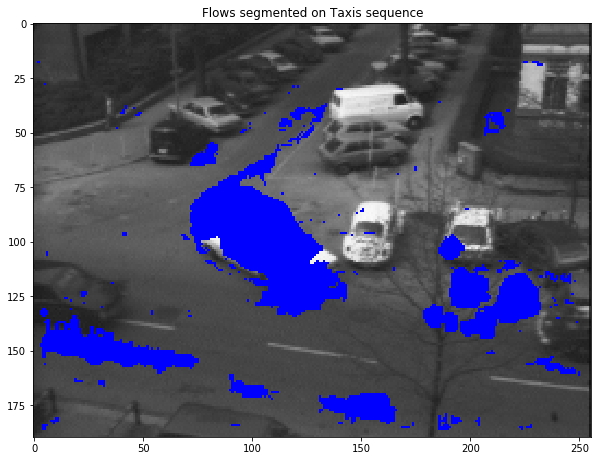

In [318]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.imshow(colored_flow)
plt.title('Flows segmented on Taxis sequence')
plt.show()

Here, for each LK flows computed between two sequence of Taxi data, we colored in blue the resuling smaller segment (kmeans). 
We can see the flow of the moving cars : the white will turn right, the far left will go along the road from left to right and the far right as well, from right to left.